1 기본설정

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치: {device}")

사용 장치: cpu


2 데이터셋 로드

In [11]:
# 정규화 (평균 0.5, 표준편차 0.5)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST
trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader_mnist = DataLoader(trainset_mnist, batch_size=64, shuffle=True)
testloader_mnist = DataLoader(testset_mnist, batch_size=64, shuffle=False)

# CIFAR-10용 정규화 (RGB 3채널)
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
trainloader_cifar = DataLoader(trainset_cifar, batch_size=64, shuffle=True)
testloader_cifar = DataLoader(testset_cifar, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]
100%|██████████| 170M/170M [00:02<00:00, 84.3MB/s]


3 MLP 모델 만들기

In [26]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):          # 입력은 x
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)            # x 사용
        return x                   # x 반환

# 모델 생성
mlp_mnist = MLP(784, 256, 10).to(device)     # m1p → mlp
mlp_cifar = MLP(3072, 256, 10).to(device)    # m1p → mlp

4 CNN 모델 만들기

In [24]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # FC 크기: MNIST (7x7), CIFAR (8x8)
        fc_size = 32 * 7 * 7 if in_channels == 1 else 32 * 8 * 8
        self.fc1 = nn.Linear(fc_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 생성
cnn_mnist = CNN(in_channels=1, num_classes=10).to(device)   # MNIST
cnn_cifar = CNN(in_channels=3, num_classes=10).to(device)   # CIFAR-10

5 훈련, 평가 함수 만들기

In [27]:
def train_model(model, trainloader, testloader, epochs=10, lr=0.001, model_name=""):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_accs, test_accs, losses = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_accs.append(train_acc)
        losses.append(running_loss / len(trainloader))

        # Test
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_acc = 100. * correct / total
        test_accs.append(test_acc)

        print(f"{model_name} Epoch {epoch+1}/{epochs} | Loss: {losses[-1]:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    return train_accs, test_accs, losses

6 모델별 학습 실행

In [28]:
print("=== MLP MNIST ===")
mlp_mnist_acc_train, mlp_mnist_acc_test, mlp_mnist_loss = train_model(
    mlp_mnist, trainloader_mnist, testloader_mnist, epochs=5, model_name="MLP-MNIST")

print("\n=== CNN MNIST ===")
cnn_mnist_acc_train, cnn_mnist_acc_test, cnn_mnist_loss = train_model(
    cnn_mnist, trainloader_mnist, testloader_mnist, epochs=5, model_name="CNN-MNIST")

print("\n=== MLP CIFAR-10 ===")
mlp_cifar_acc_train, mlp_cifar_acc_test, mlp_cifar_loss = train_model(
    mlp_cifar, trainloader_cifar, testloader_cifar, epochs=5, model_name="MLP-CIFAR")

print("\n=== CNN CIFAR-10 ===")
cnn_cifar_acc_train, cnn_cifar_acc_test, cnn_cifar_loss = train_model(
    cnn_cifar, trainloader_cifar, testloader_cifar, epochs=5, model_name="CNN-CIFAR")

=== MLP MNIST ===
MLP-MNIST Epoch 1/5 | Loss: 0.3221 | Train Acc: 90.23% | Test Acc: 94.69%
MLP-MNIST Epoch 2/5 | Loss: 0.1421 | Train Acc: 95.66% | Test Acc: 96.69%
MLP-MNIST Epoch 3/5 | Loss: 0.1063 | Train Acc: 96.64% | Test Acc: 96.26%
MLP-MNIST Epoch 4/5 | Loss: 0.0895 | Train Acc: 97.14% | Test Acc: 97.08%
MLP-MNIST Epoch 5/5 | Loss: 0.0727 | Train Acc: 97.64% | Test Acc: 97.24%

=== CNN MNIST ===
CNN-MNIST Epoch 1/5 | Loss: 0.1624 | Train Acc: 95.13% | Test Acc: 98.26%
CNN-MNIST Epoch 2/5 | Loss: 0.0461 | Train Acc: 98.58% | Test Acc: 98.52%
CNN-MNIST Epoch 3/5 | Loss: 0.0304 | Train Acc: 99.07% | Test Acc: 98.92%
CNN-MNIST Epoch 4/5 | Loss: 0.0237 | Train Acc: 99.23% | Test Acc: 98.82%
CNN-MNIST Epoch 5/5 | Loss: 0.0174 | Train Acc: 99.44% | Test Acc: 98.97%

=== MLP CIFAR-10 ===
MLP-CIFAR Epoch 1/5 | Loss: 1.6330 | Train Acc: 42.17% | Test Acc: 46.06%
MLP-CIFAR Epoch 2/5 | Loss: 1.4257 | Train Acc: 49.68% | Test Acc: 49.83%
MLP-CIFAR Epoch 3/5 | Loss: 1.3128 | Train Acc: 53.70

그래프 그리기

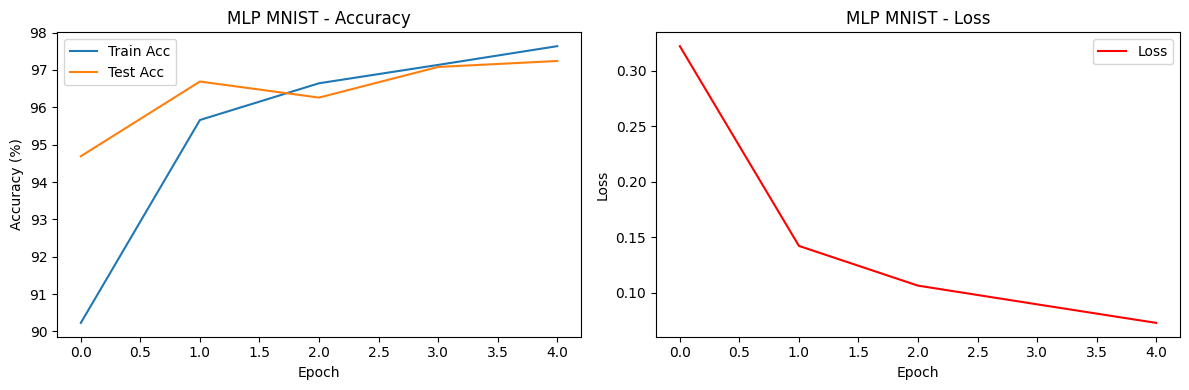

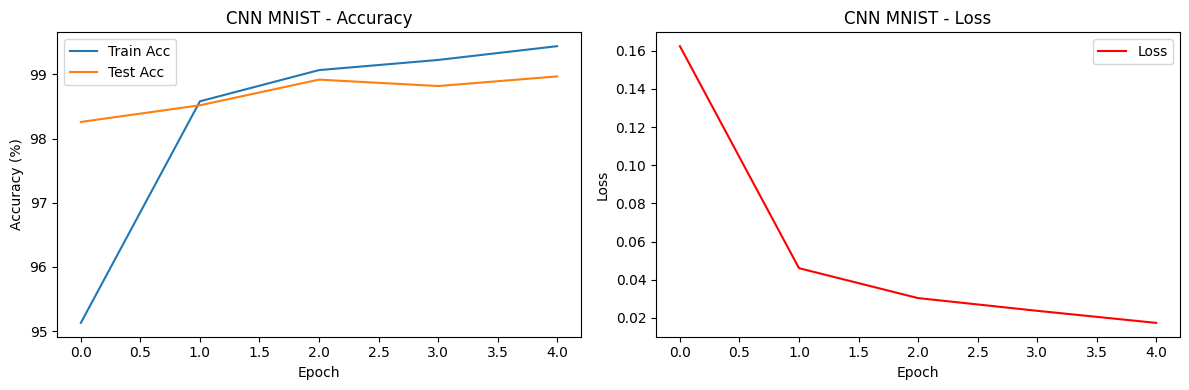

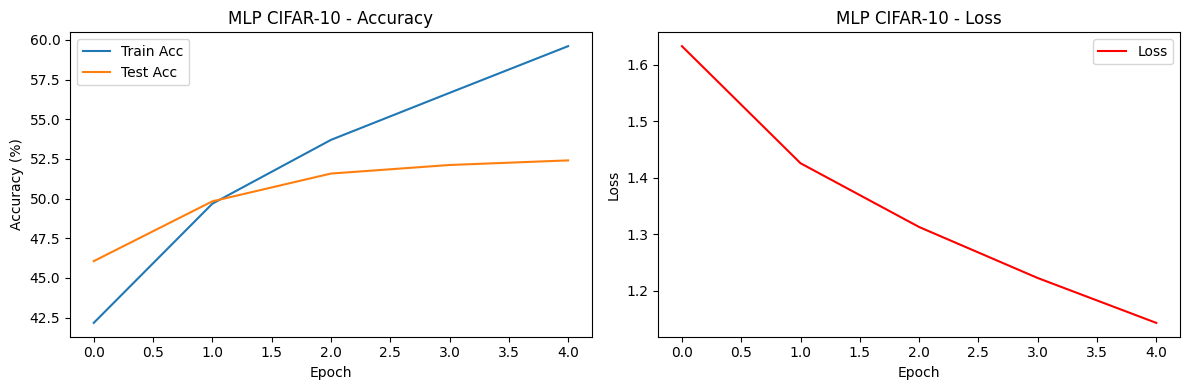

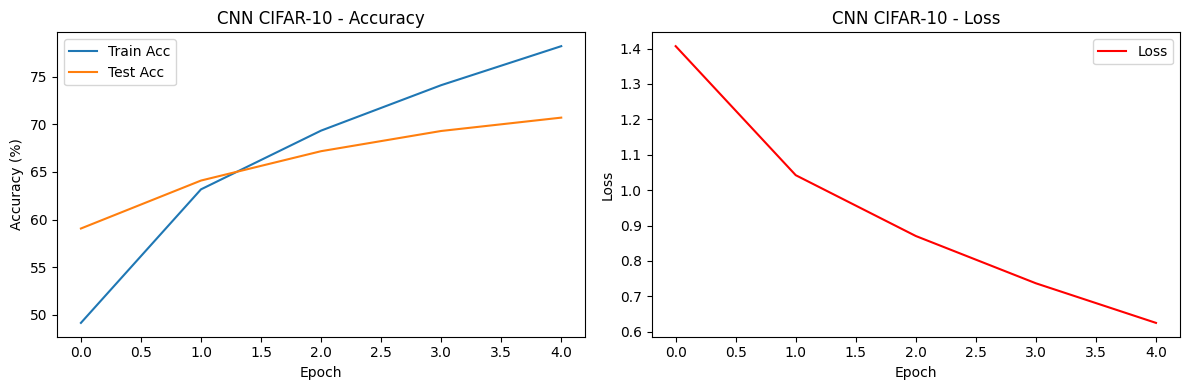

In [29]:
def plot_results(train_accs, test_accs, losses, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(losses, label='Loss', color='red')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 각각 그리기
plot_results(mlp_mnist_acc_train, mlp_mnist_acc_test, mlp_mnist_loss, "MLP MNIST")
plot_results(cnn_mnist_acc_train, cnn_mnist_acc_test, cnn_mnist_loss, "CNN MNIST")
plot_results(mlp_cifar_acc_train, mlp_cifar_acc_test, mlp_cifar_loss, "MLP CIFAR-10")
plot_results(cnn_cifar_acc_train, cnn_cifar_acc_test, cnn_cifar_loss, "CNN CIFAR-10")

파라미터 수 비교하기

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"MLP MNIST 파라미터: {count_parameters(mlp_mnist):,}")
print(f"CNN MNIST 파라미터: {count_parameters(cnn_mnist):,}")
print(f"MLP CIFAR 파라미터: {count_parameters(mlp_cifar):,}")
print(f"CNN CIFAR 파라미터: {count_parameters(cnn_cifar):,}")

MLP MNIST 파라미터: 269,322
CNN MNIST 파라미터: 813,258
MLP CIFAR 파라미터: 855,050
CNN CIFAR 파라미터: 1,059,306


softmax랑 corssentropy 구현하기

In [31]:
def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
    return exp_x / torch.sum(exp_x, dim=1, keepdim=True)

def cross_entropy_loss(logits, targets):
    log_probs = torch.log(softmax(logits))
    return -log_probs[range(len(targets)), targets].mean()

# 임의 데이터 테스트
logits = torch.randn(4, 10).to(device)
targets = torch.tensor([1, 0, 5, 3]).to(device)
my_loss = cross_entropy_loss(logits, targets)
torch_loss = nn.CrossEntropyLoss()(logits, targets)
print(f"내 Loss: {my_loss.item():.4f}, PyTorch Loss: {torch_loss.item():.4f}")

내 Loss: 3.3730, PyTorch Loss: 3.3730
